## Finding Your Way In The City (Graph Edition)
In this notebook your attention will shift from grids to graphs. At least for search ... the world representation is still a grid. You likely noticed in the previous notebook the generated paths flew as close to the obstacle / safety space as possible.

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.

In [1]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
# Should be 2.1
try:
    import networkx as nx
    assert nx.__version__ == '2.1'
except:
    import sys
    !{sys.executable} -m pip install -I networkx==2.1
    import pkg_resources
    pkg_resources.require("networkx==2.1")
    import networkx as nx
    assert nx.__version__ == '2.1'
    


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
%matplotlib inline 
import sys
sys.path.append('..')

from grid import create_grid_and_edges

In [3]:
plt.rcParams['figure.figsize'] = 12, 12

In [4]:
# This is the same obstacle data from the previous lesson.
filename = '../colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [27]:
start_ne = (750., 370.)
goal_ne = (25,  100)

In [28]:
# Static drone altitude (metres)
drone_altitude = 5
safety_distance = 3

In [29]:
# This is now the routine using Voronoi
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print(len(edges))

1895


Plot the edges on top of the grid along with start and goal locations.

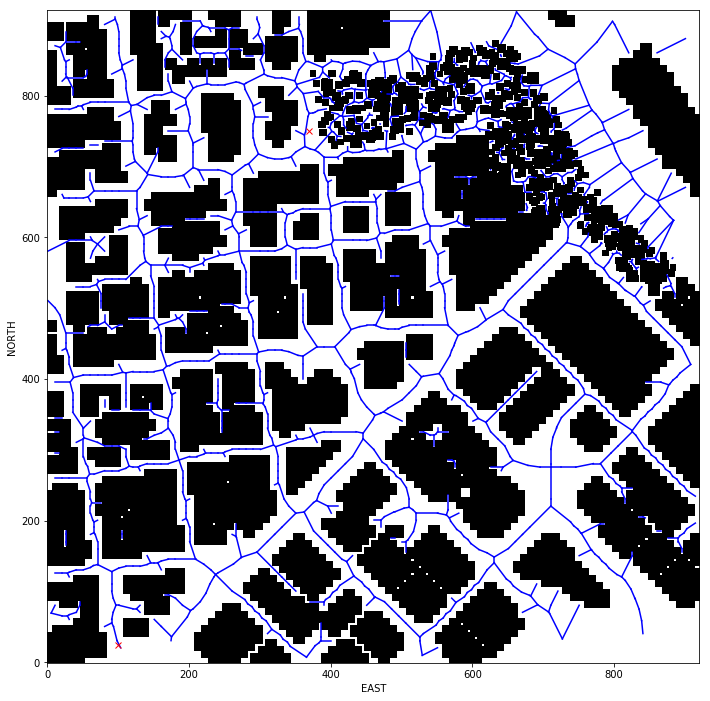

In [30]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

We now have a graph, well at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph. **NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms.

**NOTE:** In the initial import above it was imported with the `nx` alias.

You're encouraged to read the documentation but here's a super quick tour:

1. Create a graph:

```
G = nx.Graph()
```

2. Add an edge:

```
p1 = (10, 2.2)
p2 = (50, 40)
G = nx.add_edge(p1, p2)
```

3 Add an edge with a weight:

```
p1 = (10, 2.2)
p2 = (50, 40)
dist = LA.norm(np.array(p2) - np.array(p1))
G = nx.add_edge(p1, p2, weight=dist)
```

In [31]:
# TODO: create the graph with the weight of the edges
# set to the Euclidean distance between the points
G = nx.Graph()
for e in edges:
    p1 = e[0]
    p2 = e[1]
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)

In [32]:
import copy
from skimage.morphology import medial_axis, erosion
from skimage.util import invert
from medial_graph import skeleton_to_graph, simplify_graph
inv_grid = invert(grid)
erosions = 5
for _ in range(erosions):
    inv_grid = erosion(inv_grid)
skeleton = medial_axis(inv_grid, return_distance=False)
G1 = skeleton_to_graph(copy.deepcopy(skeleton))
G2 = simplify_graph(G1)

We need a method to search the graph, we'll adapt A* in order to do this. The notable differences being the actions are now the outgoing edges and the cost of an action is that weight of that edge.

### Solution

This solution consists of two parts:

1. Find the closest point in the graph to our current location, same thing for the goal location.
2. Compute the path from the two points in the graph using the A* algorithm.
3. Feel free to use any of the path pruning techniques to make the path even smaller! 

In [33]:
from astar import astar_graph_wrapper
start_ne_g, goal_ne_g, path, cost = astar_graph_wrapper(G, start_ne, goal_ne)
print(cost)

(748.7187188843021, 364.4144680930903)
(20.7611, 103.26850000000002)
Found a path.
1053.8546157533349


In [34]:
start_ne_g2, goal_ne_g2, path2, cost2 = astar_graph_wrapper(G2, start_ne, goal_ne)
print(cost2)

(740, 363)
(17, 104)
Found a path.
998.0376140280982


Use A* to compute the path.

In [35]:
grid


array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

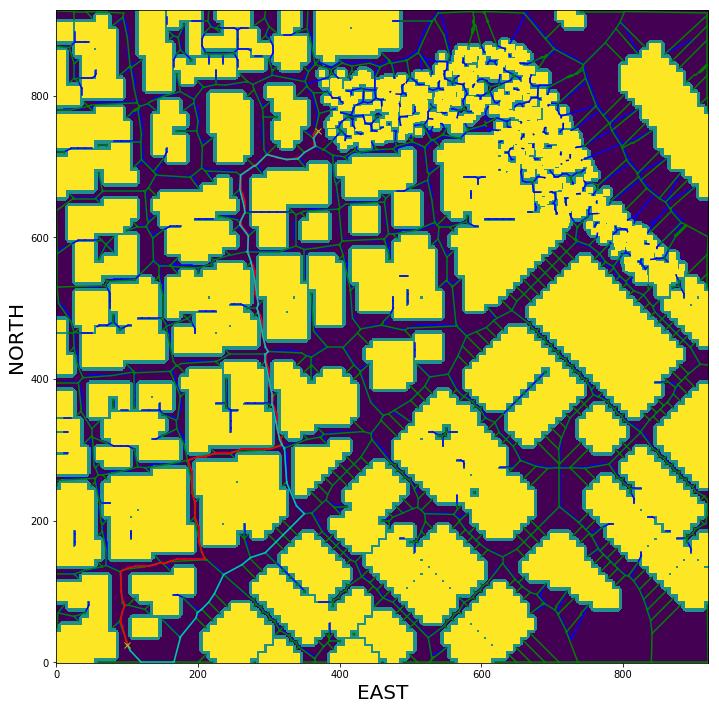

In [37]:
from visualize import plot_graph, plot_path

plt.imshow(invert(inv_grid) + grid, origin='lower') 

# plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)

plot_graph(G,'b')
plot_graph(G2, 'g')
    
plot_path(start_ne, goal_ne, path, 'r')
plot_path(start_ne, goal_ne, path2, 'c')

    
plt.plot(start_ne[1], start_ne[0], 'yx')
plt.plot(goal_ne[1], goal_ne[0], 'yx')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()